## Optimizing Model Complexity

In [1]:
import numpy as np
import pandas as pd
from math import pi,exp

import matplotlib.pyplot as plt
%matplotlib inline

### Load the Data
Read the training data from file scores-train_1.csv. The first two columns are x1 and x2. The last column holds the class label y. Compose suitable numpy array structures.

In [2]:
trainset = pd.read_csv('scores_train_1.csv',names=['x1','x2','y'])
testset = pd.read_csv('scores_test_1.csv',names=['x1','x2','y'])

#data is a pandas "DataFrame" with different keys
print(type(trainset))
#show the keys of digit
print(trainset.keys())
#get data i.e. the points (x) and labels (y)
x_train_orig = np.append(trainset['x1'].values.reshape(100,1), trainset['x2'].values.reshape(100,1),1)
x_test_orig = np.append(testset['x1'].values.reshape(100,1), testset['x2'].values.reshape(100,1),1)
#we convert the labels here to int
y_train = np.array(trainset['y'].values, dtype='int').reshape(100,1)
y_test = np.array(testset['y'].values, dtype='int').reshape(100,1)
#get the respective shape
print('x_train_orig shape: %r, x_test_orig shape: %r' % (x_train_orig.shape, x_test_orig.shape))
print('y_train shape: %r, y_test shape: %r' % (y_train.shape, y_test.shape))

<class 'pandas.core.frame.DataFrame'>
Index(['x1', 'x2', 'y'], dtype='object')
x_train_orig shape: (100, 2), x_test_orig shape: (100, 2)
y_train shape: (100, 1), y_test shape: (100, 1)


In [3]:
def plot_data(x, y, fig_size = [6,6]):
    """
    plot data x with different labels according y

    Arguments:
    x -- array m x 2 data to plot
    y -- binary labels {0,1}
    """
    
    fig = plt.figure(figsize = fig_size)
    ax = fig.subplots()
    ax.plot(x[y[:,0]==0,0], x[y[:,0]==0,1],'bo')
    ax.plot(x[y[:,0]==1,0], x[y[:,0]==1,1],'rx')
   

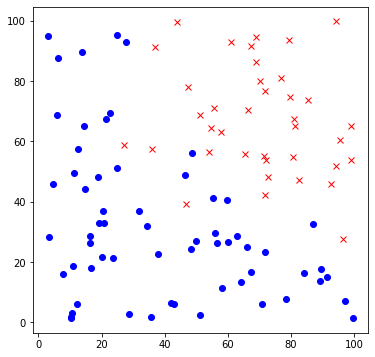

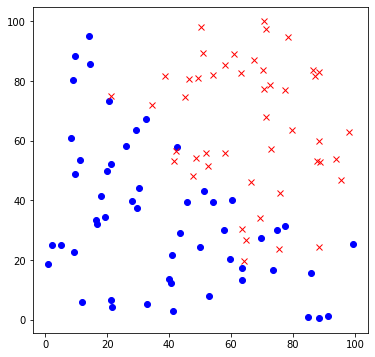

In [4]:
plot_data(x_train_orig,y_train)
plot_data(x_test_orig,y_test)

### Normalisation

We must normalise our input data, because this is important for the stability of the optimisation. Usually this normalisation is done for each feature component individually. However, here our features will represent different terms of a polynomial function (e.g. for order two $(x_1,x_2,x_1^2,x_2^2,x_1x_2)$, c.f. function `polynomial_features` below). Therefore the features have a defined mathematical relation with respect to each other and must not be normalised individually. Therefore we only normalise the inputs $(x_1,x_2)$ and then calculate the different powers of these input terms. This is similar to image normalisation, where all pixels i.e. features are normalised together.

In [5]:
def normalise(x_train_orig, x_test_orig):
    """
    Arguments:
    x_train_orig -- raw train data set
    x_test_orig -- raw test data set
    
    Returns:
    N(0,1) normalised train and test data set
    """
    ### START YOUR CODE ###

    mean = x_train_orig.mean(axis=0)
    std = x_train_orig.std(axis=0)
    
    x_train = (x_train_orig - mean) / std
    x_test = (x_test_orig - mean) / std

    ### END YOUR CODE ###
    
    return x_train, x_test

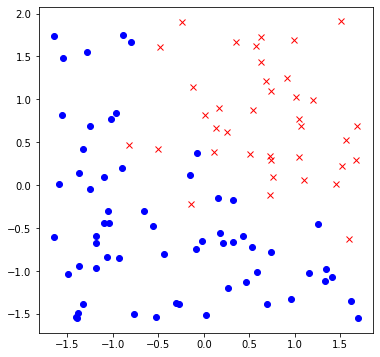

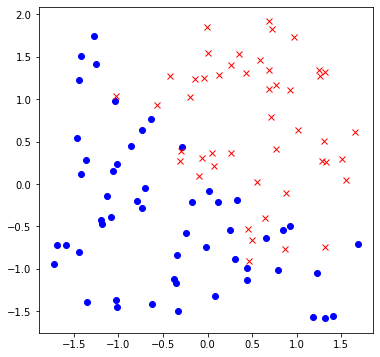

In [6]:
#perform and verify normalisation
x_train, x_test = normalise(x_train_orig, x_test_orig)

plot_data(x_train,y_train)
plot_data(x_test,y_test)

### Modelling

We consider different models of different complexities involving different number of parameters. All these models involve combinations of powers in $x_1,x_2$ and are of the form

$\quad g(x_1,x_2) = \sigma(h(x_1,x_2)), \quad h(x_1,x_2)=b_0 + \sum_{k=1}^n w_k \phi_k(x_1,x_2)$

with $\phi_k$  multinomials in $x_1,x_2$ (i.e. combinations of powers in $x_1,x_2$). The decision boundary is then given by $h(x_1,x_2)=0$. This can be formulated by a linear model of the form $\mathbf{w}\cdot\mathbf{x}$ by adding different dimensions to the input data with suitable powers of the prime input data $x_1,x_2$.

Specifically, we consider the following situations:

* Linear Affine: $h(x_1,x_2) = b_0 + w_1x_1 + w_2x_2$ where $\mathbf{x}=(x_1,x_2)$

* Quadratic: $h_2(x_1,x_2) = b_0 + w_1x_1 + w_2x_2 + w_3x_3 + w_4x_4 + w_5x_5$ where $\mathbf{x}=(x_1,x_2,x_1^2,x_2^2,x_1x_2)$

* etc.

The constant term $b_0$ will be taken care of by the bias value of our model below

All the above models are linear in the parameters. We can use the same optimisation function.

The method `polynomial_features` below will help you to extend the input dataset by additional dimensions up to a given polynomial order.

In [7]:
def polynomial_features(x, order):
    """
    Arguments:
    x -- input data as numpy array of shape (2,m) where m is the number of samples
    order -- the max order of terms to be added (x1^j*x2^i and i+j<=order)
    
    Returns:
    numpy array of shape (n,m) where n = (order+1)*(order+2)/2 (all the monomials x1^j*x2^i and i+j<=order)
    """
    m = x.shape[0]
    x1,x2 = x[:,0:1],x[:,1:2]
    features = x.copy()
    n = 3
    if order > 1:
        for i0 in range(2,order+1):
            for term in range(i0+1):
                features = np.append(features, (x1**(i0-term)*x2**term).reshape(m,1), axis=1)
                n += 1
    return features

### Class GradientDescent

This class summarises the gradient descent steps. The training and test data is given as dictionary (c.f. cell directly below the class definition for an example). The class can be called, however only a dummy implementation is given (weigths w and bias b are always 0). Replace the dummy parts with your own implementation and test it.

In [8]:
class GradientDescent:    
    """
    obtains train and test data in the constructor and does the gradient descend
    """    
    def __init__(self, data, alpha = 0.5, random_std = 0):
        """
        constructor
        
        Arguments:
        data -- dictionary with data
        alpha -- learning rate
        random_std -- std for initialisation of weight (default is 0)
        """
        #keep local copy of data
        self.data = data
        self.alpha = alpha
        
        #as explained above we do not normalize data
        #self.normalise_data()
        
        #initialize weights and bias (zero or random)
        self.initialise_weights(random_std)
        
        #result array
        self.result_data = np.array([])
      
    
    def normalise_data(self):
        """
        normalize the input data
        """    
        #separate normalisation of train and test data
        self.norm = {'mean': np.mean(self.data['x_train'],0), 'std': np.std(self.data['x_train'],0)}
        
        self.data['x_train'] = (self.data['x_train'] - self.norm['mean'])/self.norm['std']
        self.data['x_test'] = (self.data['x_test'] - self.norm['mean'])/self.norm['std']
    
    
    def initialise_weights(self, random_std):
        """
        initialise weights
        """ 
        #initialize weights and bias (if random_std == 0 all weights are zero)
        self.w = random_std*np.random.randn(self.data['x_train'].shape[1],1)
        self.b = 0
    
    
    def calc_error(self, y_pred, y):
        """
        get error information
        """
        m = y.shape[0]
        
        res = np.round(y_pred)        
        train_error = np.sum(np.abs(res - y)) / m 
        
        return train_error
    
        
    def append_result(self, res_data):
        """
        append cost and error data to output array
        """  
        #first call
        if self.result_data.size == 0:
            self.result_data = res_data
        else:
            self.result_data = np.append(self.result_data, res_data, 0)
            
        return res_data
            

    def cost_funct(self, y_pred, y):
        """
        calculates the chosen cost function for given values of w and b
        """
        m = y.shape[0]
        
        #take care of possible over over or underflow
        eps=1.0e-12
        y_pred = np.clip(y_pred,eps,1-eps)
        cost = -np.sum((y.T @ np.log(y_pred) + (1 - y).T @ np.log(1-y_pred)) / m)                    
                            
        return cost   
    
    
    def grad_cost(self):
        """
        calculates the gradients of cost function wrt w and b
        """
        #abbreviation
        y_pred = self.y_pred[0]
        x = self.data['x_train']
        y = self.data['y_train']
        m = x.shape[0]
        
        ### START YOUR CODE ###
        
        grad_w = (y_pred - y).T @ x / m
        grad_b = np.mean(y_pred - y, 0)
            
        ### END YOUR CODE ###
                                      
        return grad_w.T, grad_b
    
    
    def predict(self, x):
        """
        implementation of sigmoid function
        """        
        ### START YOUR CODE ###
        sigmoid = lambda z: 1 / (1 + np.exp(-z))
        
        return sigmoid(x @ self.w + self.b)
    
        ### END YOUR CODE ###
              
    
    def update(self):
        """
        performs one gradient descend step
        """
        #predicted outcome for train [0] and test data [1]
        self.y_pred = [self.predict(self.data['x_train']), self.predict(self.data['x_test'])]
        
        grad_w, grad_b = self.grad_cost()
        self.w -= self.alpha * grad_w
        self.b -= self.alpha * grad_b
        
        
    def det_result_data(self, epochs):
        """
        predict outcome for train [0] and test data [1] as well as cost functions
        """
        self.y_pred = [self.predict(self.data['x_train']), self.predict(self.data['x_test'])]

        # determine cost functions for train [0] and test data [1]
        self.cost = [self.cost_funct(self.y_pred[0], self.data['y_train']),
                     self.cost_funct(self.y_pred[1], self.data['y_test'])]

        res_data = np.array([[epochs, self.cost[0], self.calc_error(self.y_pred[0], self.data['y_train']),
                              self.cost[1], self.calc_error(self.y_pred[1], self.data['y_test'])]])

        return res_data

    
    def save_results(self, i_step):
        """
        save data to result array
        """
        res_data = self.det_result_data(i_step)

        self.append_result(res_data)

        return res_data
        
        
    def optimise(self, epochs, debug = False):
        """
        performs epochs number of gradient descend steps and appends result to output array
        
        Arguments:
        debug -- False (default)/True; get info on each gradient descend step
        """
        # save results before step
        res_data = self.save_results(0)
        
        for i0 in range(0,epochs):
            self.update()
            res_data = self.save_results(i0+1)
            if debug and np.mod(i0,1) == 0:
                print('step %r, cost %r, error %r' %(i0, res_data[0,1], res_data[0,2]))
                
        print('result after %d epochs, train: cost %.5f, error %.5f ; test: cost %.5f, error %.5f' 
                                %(epochs, res_data[0,1], res_data[0,2], res_data[0,3], res_data[0,4]))
        
    
        

### Sample execution of gradient descent

The cell below shows how to use the class GradientDescent to perform the optimisation. The training and test data is given as dictionary in the constructor of the class. Then the method optimise is called with first argument being the number of epochs.


In [9]:
#define order of polynomial (try from 1 to ~7 typically)
order = 1
x_train_p = polynomial_features(x_train, order)
x_test_p = polynomial_features(x_test, order)

#data is arranged as dictionary with quick access through respective keys
data = {'x_train' : x_train_p, 'y_train' : y_train, 'x_test' : x_test_p, 'y_test' : y_test}

#we use CE cost (3rd argument) and Xavier initialisation (4th argument)
gradD = GradientDescent(data, 0.1, 1/np.sqrt(order))

gradD.optimise(4000,False)

result after 4000 epochs, train: cost 0.20906, error 0.07000 ; test: cost 0.31963, error 0.16000


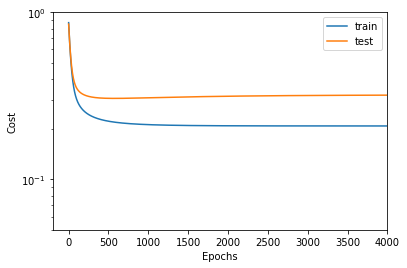

In [10]:
#analyse cost as function of epochs
epochs = gradD.result_data[:,0]
train_costs = gradD.result_data[:,1]
test_costs = gradD.result_data[:,3]

plt.semilogy(epochs, train_costs, label="train")
plt.semilogy(epochs, test_costs, label="test")
plt.ylabel('Cost')
plt.xlabel('Epochs')
xmax = epochs[-1]
ymin = 5e-2
ymax = 1
plt.axis([-xmax/20,xmax,ymin,ymax])
plt.legend()
plt.show() 

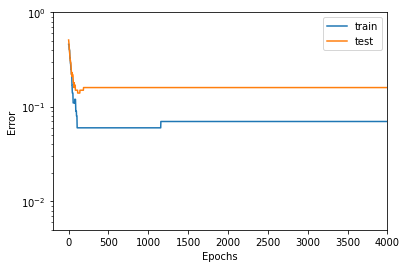

In [11]:
#analyse error as function of epochs
epochs = gradD.result_data[:,0]
train_error = gradD.result_data[:,2]
test_error = gradD.result_data[:,4]

plt.semilogy(epochs, train_error, label="train")
plt.semilogy(epochs, test_error, label="test")
plt.ylabel('Error')
plt.xlabel('Epochs')
xmax = epochs[-1]
ymin = 5e-3
ymax = 1
plt.axis([-xmax/20,xmax,ymin,ymax])
plt.legend()
plt.show() 

In [12]:
def plot_data_and_boundary(data_type, steps = 100, fig_size = [6,6]): 
    """
    show set of data points and decision boundary
    the correct classified points are open and the false classified closed circles respectively

    Arguments:
    data_type -- choose data type to represent ('train' or 'test')
    steps -- number of points for representation of decision boundary
    """
    
    if data_type == 'train':
        x = gradD.data['x_train']
        y = gradD.data['y_train']
    else:
        x = gradD.data['x_test']
        y = gradD.data['y_test']
        
    #construct a grid of data points and predict the outcome    
    interval = [np.min(x[:,:2],0),np.max(x[:,:2],0)]
         
    dx = (interval[1][0] - interval[0][0]) / steps
    dy = (interval[1][1] - interval[0][1]) / steps
    grid = np.mgrid[interval[0][0]:interval[1][0]:dx,interval[0][1]:interval[1][1]:dy]

    grid_points = grid.reshape(2,int(grid.size/2)).T

    y_pred = gradD.predict(polynomial_features(grid_points, order))
    
    #determine the false classifications
    false_ind = (y != np.round(gradD.predict(x)))

    #plot everything
    fig = plt.figure(figsize = fig_size)
    ax = fig.subplots()
    #all samples (open circles)
    ax.plot(x[y[:,0]==0,0], x[y[:,0]==0,1],'bo', fillstyle = 'none')
    ax.plot(x[y[:,0]==1,0], x[y[:,0]==1,1],'ro', fillstyle = 'none')
    #false classified samples (filled circles)
    ax.plot(x[(y[:,0]==0)*false_ind[:,0],0], x[(y[:,0]==0)*false_ind[:,0],1],'bo')
    ax.plot(x[(y[:,0]==1)*false_ind[:,0],0], x[(y[:,0]==1)*false_ind[:,0],1],'ro')
    #plot contour to heigth 0.5 -> sigmoid (you can add other levels)
    ax.contour(grid[0,:,:], grid[1,:,:], y_pred.reshape(grid[0].shape), levels=[0.5], cmap=plt.cm.Paired)

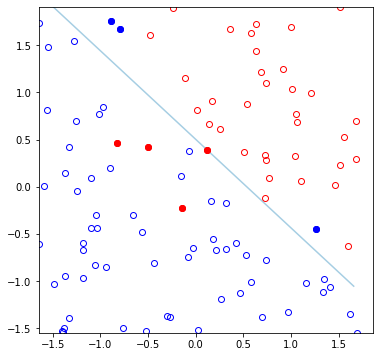

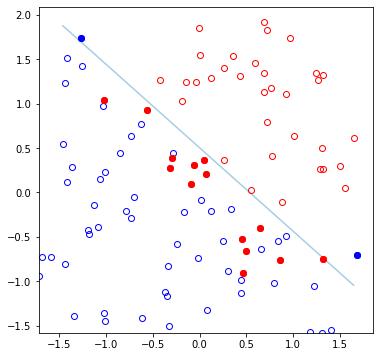

In [13]:
#plot the result
plot_data_and_boundary('train')
plot_data_and_boundary('test')

Order is 1
result after 4000 epochs, train: cost 0.20905, error 0.07000 ; test: cost 0.31978, error 0.16000
Order is 2
result after 4000 epochs, train: cost 0.11947, error 0.06000 ; test: cost 0.29422, error 0.10000
Order is 3
result after 4000 epochs, train: cost 0.09830, error 0.04000 ; test: cost 0.37342, error 0.10000
Order is 4
result after 4000 epochs, train: cost 0.09441, error 0.05000 ; test: cost 0.38761, error 0.12000
Order is 5
result after 4000 epochs, train: cost 0.08668, error 0.04000 ; test: cost 0.43434, error 0.11000
Order is 6
result after 4000 epochs, train: cost 0.08493, error 0.04000 ; test: cost 0.46342, error 0.11000
Order is 7
result after 4000 epochs, train: cost 0.07746, error 0.04000 ; test: cost 0.51992, error 0.11000


Text(0.5, 1.0, 'Train/test error for polynominal order')

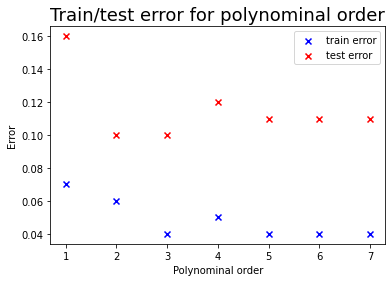

In [14]:
#hyperparameter optimisation
#determine train and test error rates for polynomial order of 1 to 7 and analyse the result in a graph

### START YOUR CODE ###
        
NB_ORDER = 7

fig, ax = plt.subplots()

train_error_list = []
test_error_list = []
train_learning_curves = []
test_learning_curves = []

for order in range(1,NB_ORDER+1):
    print(f"Order is {order}")
    
    x_train_p = polynomial_features(x_train, order)
    x_test_p = polynomial_features(x_test, order)

    #data is arranged as dictionary with quick access through respective keys
    data = {'x_train' : x_train_p, 'y_train' : y_train, 'x_test' : x_test_p, 'y_test' : y_test}

    #we use CE cost (3rd argument) and Xavier initialisation (4th argument)
    gradD = GradientDescent(data, 0.1, 1/np.sqrt(order))

    gradD.optimise(4000,False)
    
    train_error = gradD.result_data[-1:,2]
    test_error = gradD.result_data[-1:,4]
    
    train_error_list.append(train_error)
    test_error_list.append(test_error)
    
    train_learning_curves.append(gradD.result_data[:,1])
    test_learning_curves.append(gradD.result_data[:,3])
    
ax.scatter(list(range(1, NB_ORDER+1)), train_error_list, marker='x', color='blue', label='train error')
ax.scatter(list(range(1, NB_ORDER+1)), test_error_list, marker='x', color='red', label='test error')
ax.legend()
ax.set_xlabel('Polynominal order')
ax.set_ylabel('Error')
ax.set_title('Train/test error for polynominal order', fontsize=18)

### END YOUR CODE ###

Note : This comment is for dataset 1
* It can be seen that the polynomial of degree 1 has a fairly high error. The model is underfit. 
* The error goes back down for the degree 2 and 3. 
* Then the error goes back up for the polynomials of degree greater than 3. These models overfit 
* We can see that the optimal degrees for the polynomial is degree **2 or 3**, it is at these points that the error of the train and the test set is the lowest.

In [15]:
def plot_polynoms_learning_curves(curves, title, ymin): 
    """
    Allow to plot learning curves for each polynominal order
    """
    fig, ax = plt.subplots(figsize=(10,6))
    for i, l in enumerate(curves):
        ax.semilogy(range(0, len(l)), l, label=(i+1))
        
    ax.set_ylabel('Cost')
    ax.set_xlabel('Epochs')
    ax.set_title(title, fontsize=18)
    
    ymax = 1

    ax.set_ylim([ymin, ymax])
    ax.legend()

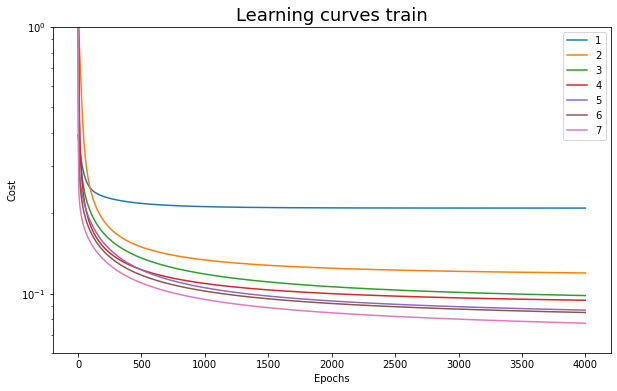

In [16]:
plot_polynoms_learning_curves(train_learning_curves, 'Learning curves train', 6e-2)

Note : This comment is for dataset 1
* Naturally we see that as the degree of the polynomial increases, the training error decreases. This is because the higher the degree the more the polynomial adapts to the training data and overfit

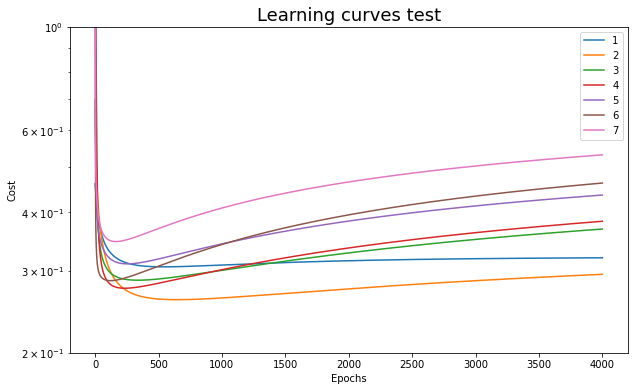

In [17]:
plot_polynoms_learning_curves(test_learning_curves, 'Learning curves test',20e-2)

Note : This comment is for dataset 1
* Here, the same observations can be made as on the error graph. We can see that from degree 3, the cost starts to increase and that the model overfits. This graph allows to confirm that the best degree of the polynomial are 2 and 3 in term of cost

# Unit Tests
### Unit Test for normalise¶

In [18]:
x1 = np.array([1,2,3,-4,5,3,1,2,5,1,2,-2,3,-3,1,4]).reshape(8,2)
x2 = np.array([3,5,1,1,2,3,2,-2,-3,1,3,-4,1,2,5,-3]).reshape(8,2)

x1n, x2n = normalise(x1, x2)
x1n_exp = np.array([[-1.03096706,  0.58430655],
        [ 0.23791548, -1.57313301],
        [ 1.50679801,  0.94387981],
        [-1.03096706,  0.58430655],
        [ 1.50679801,  0.22473329],
        [-0.39652579, -0.85398649],
        [ 0.23791548, -1.21355975],
        [-1.03096706,  1.30345307]])
x2n_exp = np.array([[ 0.23791548,  1.66302633],
        [-1.03096706,  0.22473329],
        [-0.39652579,  0.94387981],
        [-0.39652579, -0.85398649],
        [-3.56873214,  0.22473329],
        [ 0.23791548, -1.57313301],
        [-1.03096706,  0.58430655],
        [ 1.50679801, -1.21355975]])
np.testing.assert_array_almost_equal(x1n,x1n_exp,decimal=8)
np.testing.assert_array_almost_equal(x2n,x2n_exp,decimal=8)

### Unit Test for predict¶

In [19]:
#create dummy instance
hx = np.ones((2,2))
hy = np.ones((2,1))
data = {'x_train' : hx, 'y_train' : hy, 'x_test' : hx, 'y_test' : hy}
gradD = GradientDescent(data, 0.1, 0)

gradD.w = np.arange(-1.,1.1,0.5).reshape(5,1)
gradD.b = 0.25
x = np.array([[1,2,3,-4,5],[3,1,2,5,1],[2,-2,3,-3,1]])
y_pred = gradD.predict(x)
y_pred_exp = np.array([0.77729986,0.5621765,0.22270014]).reshape(y_pred.shape)
np.testing.assert_array_almost_equal(y_pred,y_pred_exp,decimal=8)

### Unit Test for grad_cost
Assumes that Unit Test for predict is correct!

In [20]:
#create dummy instance
hx = np.array([[1,2,3,-4,5],[3,1,2,5,1],[2,-2,3,-3,1]])
hy = np.array([[1],[0],[1]])
data = {'x_train' : hx, 'y_train' : hy, 'x_test' : hx, 'y_test' : hy}
gradD = GradientDescent(data, 0.1, 0)

gradD.w = np.arange(-1.,1.1,0.5).reshape(5,1)
gradD.b = 0.25
y_pred = gradD.predict(hx)
gradD.y_pred = [y_pred, y_pred]

dw, db = gradD.grad_cost()
dw_exp = np.array([-0.03025679, 0.55712532,-0.62521567, 2.01119421,-0.44287468]).reshape(dw.shape)
db_exp = np.array([-0.14594117]).reshape(db.shape)
np.testing.assert_array_almost_equal(dw,dw_exp,decimal=8)
np.testing.assert_array_almost_equal(db,db_exp,decimal=8)